## Take-home evaluation for the Computer Vision Scientist as part of the Modelling team of the Enigma project

This evaluation is designed to take approximately 4-5 hours to complete. We greatly appreciate your time and effort in completing this task and we're looking forward to reviewing your solution.

An interesting task that we are facing in this project is the creation of a library of annotated natural movies using state-of-the-art methods, as a basis for further exploration of the representation of visual latents in the primate brain and in large-scale multimodal models.

For this take home assessment, the task is to annotate an example video with modalities of your own choosing - geometric, semantic, RGB, and reflect on the results.

It is not necessary to run the analysis on a large scale or with a lot of compute. We're more interested in the quality of the code that you produce and how you approach the problem.

## Download the example video

In [1]:
!wget https://download.blender.org/demo/movies/ToS/tears_of_steel_720p.mov
example_video = "./tears_of_steel_720p.mov"


--2024-12-24 10:47:07--  https://download.blender.org/demo/movies/ToS/tears_of_steel_720p.mov
Resolving download.blender.org (download.blender.org)... 104.22.65.163, 172.67.14.163, 104.22.64.163, ...
Connecting to download.blender.org (download.blender.org)|104.22.65.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 372178639 (355M) [video/quicktime]
Saving to: ‘tears_of_steel_720p.mov’

tears_of_steel_720p 100%[===================>] 354.94M   244MB/s    in 1.5s    

2024-12-24 10:47:09 (244 MB/s) - ‘tears_of_steel_720p.mov’ saved [372178639/372178639]



# The Task

Now, the task is simply to use this video and compute annotations/modalities such as:

- Geometric modalities (Depth, Surface normals, poses, ...)
- Semantic modalities (Semantic segmentation, bounding boxes, ...)
- Edge modalities
- Feature maps of SOTA models (Clip, ...)

1) You can choose however many modalities that you're interested in and that you are most familiar with.

2) Demonstrate the annotations on a small subset of the video (5-10 seconds or even shorter is enough) that showcases the strength of the method.

3) Reflect on the results of this method - do you see failure cases? Are there stronger methods that you could envision, but that are not possible to implement/use for a short demo? Is it possible to quantify the annotations, so that a large database of videos can be compared with regard to this particular modality?

This is a very open ended task, and a complete implementation of all of these capabilities would require days or weeks. You can focus on the part that you have the most experience in and that seems most interesting to you.

For all of these tasks, all open source libraries can be used. It is not necessary that all of the code actually runs in this notebook. We're much more interested in how you approach the problem and how your solution is implemented.




# 1. Geometric modalities

**Depth**


In [5]:
import os
import cv2
import torch
import numpy as np
import urllib.request

def load_midas_model(
    model_type="DPT_Large", device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Loads MiDaS model from Torch Hub or from a local checkpoint.
    """
    print("Loading MiDaS model...")
    # Option A: Load from torch.hub
    model = torch.hub.load("intel-isl/MiDaS", model_type)

    # Switch model to evaluation mode
    model.eval()

    # Load transforms required by the model
    transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    if "DPT" in model_type:
        transform = transforms.dpt_transform
    else:
        transform = transforms.midast_transform

    model.to(device)

    return model, transform, device

def estimate_depth_frame(frame, model, transform, device):
    """
    Takes a BGR frame (OpenCV) as input, applies MiDaS preprocessing,
    and returns a depth map (H x W).
    """
    # Convert from BGR to RGB
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Apply MiDaS transforms
    input_batch = transform(img_rgb).to(device)

    with torch.no_grad():
        prediction = model(input_batch)

        # For DPT models, output is sometimes a list: we take the first tensor
        if isinstance(prediction, list):
            prediction = prediction[0]

        # Remove extra dimension and convert to CPU numpy
        depth = prediction.squeeze().cpu().numpy()

    # Normalize depth for visualization or further processing
    # (optional but often useful)
    depth_min, depth_max = depth.min(), depth.max()
    depth_norm = (depth - depth_min) / (depth_max - depth_min + 1e-8)

    return depth_norm

def process_video_depth(video_path, output_folder="depth_frames", skip=1,max_save=3):
    """
    Reads a video file frame by frame, estimates depth for each frame,
    and saves a normalized depth image per frame.

    :param video_path: Path to input video
    :param output_folder: Directory where depth images will be saved
    :param skip: Process every Nth frame (e.g., skip=1 means every frame)
    :param max_save: Maximum number of frames to save
    """
    # Create output folder if not existing
    os.makedirs(output_folder, exist_ok=True)

    # Load MiDaS model
    model, transform, device = load_midas_model(model_type="DPT_Large")

    # Open video capture
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    frame_count = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # No more frames

        frame_count += 1

        # Only estimate depth for every Nth frame if skip > 1
        if frame_count % skip != 0:
            continue

        # Estimate depth
        depth_map = estimate_depth_frame(frame, model, transform, device)

        # Convert to color map for visualization
        # Note: using COLORMAP_MAGMA, but you can choose any other
        depth_colored = cv2.applyColorMap(
            (depth_map * 255).astype(np.uint8), cv2.COLORMAP_MAGMA
        )

        # Save the depth map (colored) to the output folder
        output_path = os.path.join(output_folder, f"depth_{saved_count:05d}.png")
        cv2.imwrite(output_path, depth_colored)

        saved_count += 1

        # Terminate after saving max_save frames
        if saved_count >= max_save:
            print(f"Reached the maximum of {max_save} saved frames. Terminating.")
            break

        # (Optional) Show current depth map
        # cv2.imshow("Depth", depth_colored)
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    # Clean up
    cap.release()
    # cv2.destroyAllWindows()

    print(f"Total frames processed: {frame_count}, depth maps saved: {saved_count}")

#RUN BELOW
"""
process_video_depth("./3_faces.mp4", output_folder="depth_frames/depth_3_faces", skip=20, max_save=3)
process_video_depth("./girl_boy.mp4", output_folder="depth_frames/depth_girl_boy", skip=20, max_save=3)
process_video_depth("./girl_boy_drawing.mp4", output_folder="depth_frames/depth_girl_boy_drawing", skip=20, max_save=3)
"""



# 2. Segmentation


In [53]:
import torch
import torchvision.transforms as T
from PIL import Image
import cv2
import numpy as np

# Load the DeepLabv3 model
model = torch.hub.load('pytorch/vision:v0.13.1', 'deeplabv3_resnet101', pretrained=True)
model.eval()

# Define the standard transformation
preprocess = T.Compose([
    T.ToPILImage(),
    T.Resize(520),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])


Downloading: "https://github.com/pytorch/vision/zipball/v0.13.1" to /root/.cache/torch/hub/v0.13.1.zip
  warnings.warn(

  warnings.warn(msg)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:05<00:00, 45.7MB/s]


In [63]:
import os
import torch
import torchvision.transforms as T
import cv2
import numpy as np

def decode_segmap(image, nc=21):
    """
    Decode segmentation class labels into a color image.
    """
    label_colors = np.array([
        (0, 0, 0),        # 0=background
        (128, 0, 0),      # 1=aeroplane
        (0, 128, 0),      # 2=bicycle
        (128, 128, 0),    # 3=bird
        (0, 0, 128),      # 4=boat
        (128, 0, 128),    # 5=bottle
        (0, 128, 128),    # 6=bus
        (128, 128, 128),  # 7=car
        (64, 0, 0),       # 8=cat
        (192, 0, 0),      # 9=chair
        (64, 128, 0),     # 10=cow
        (192, 128, 0),    # 11=diningtable
        (64, 0, 128),     # 12=dog
        (192, 0, 128),    # 13=horse
        (64, 128, 128),   # 14=motorbike
        (192, 128, 128),  # 15=person
        (0, 64, 0),       # 16=potted plant
        (128, 64, 0),     # 17=sheep
        (0, 192, 0),      # 18=sofa
        (128, 192, 0),    # 19=train
        (0, 64, 128)      # 20=tv/monitor
    ])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def main():
    # ------------------------ Configuration ------------------------ #

    # Path to the input video
    video_path = './girl_boy.mp4'  # Replace with your video path

    # Output directory to save segmented frames
    output_dir = 'segmented_frames'  # Replace with your desired output directory

    # Number of frames to process
    num_frames_to_process = 3

    # ---------------------------------------------------------------- #

    # Check and create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory at '{output_dir}'")
    else:
        print(f"Output directory exists at '{output_dir}'")

    # Check if CUDA is available and set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load the DeepLabv3 model
    print("Loading DeepLabv3 model...")
    model = torch.hub.load('pytorch/vision:v0.13.1', 'deeplabv3_resnet101', pretrained=True)
    model.to(device)
    model.eval()
    print("Model loaded successfully.")

    # Define the standard transformation
    preprocess = T.Compose([
        T.ToPILImage(),
        T.Resize(520),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
    ])

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video '{video_path}'. Please check the path.")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"Video Properties:\n - Frame Width: {frame_width}\n - Frame Height: {frame_height}\n - FPS: {fps}\n - Total Frames: {total_frames}")

    # Initialize counters
    processed_frames = 0

    print(f"\nStarting processing of the first {num_frames_to_process} frames...\n")

    while cap.isOpened() and processed_frames < num_frames_to_process:
        ret, frame = cap.read()
        if not ret:
            print("Reached end of video or encountered an error.")
            break

        # Preprocess the frame
        input_tensor = preprocess(frame).to(device)
        input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

        with torch.no_grad():
            output = model(input_batch)['out'][0]
        output_predictions = output.argmax(0).byte().cpu().numpy()

        # Decode the segmentation map
        seg_map = decode_segmap(output_predictions)

        # Resize seg_map to original frame size if needed
        seg_map = cv2.resize(seg_map, (frame_width, frame_height), interpolation=cv2.INTER_NEAREST)

        # Blend the segmentation map with the original frame
        blended = cv2.addWeighted(frame, 0.5, seg_map, 0.5, 0)

        # Convert BGR (OpenCV) to RGB for correct color representation if needed
        # blended_rgb = cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)

        # Save the blended image as PNG
        output_image_path = os.path.join(output_dir, f'segmented_frame_{processed_frames + 1}.png')
        cv2.imwrite(output_image_path, blended)
        print(f"Saved segmented frame {processed_frames + 1} as '{output_image_path}'")

        processed_frames += 1

    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    print(f"\nProcessing complete. {processed_frames} frames saved in '{output_dir}'.")



# 3. Object detection

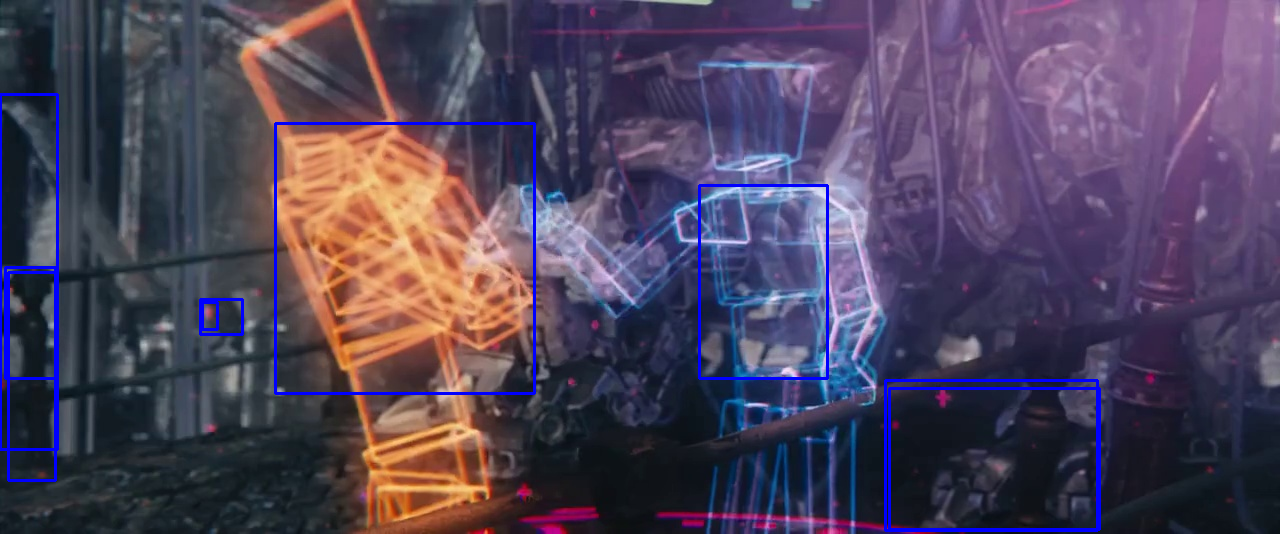

-1

In [17]:
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from google.colab.patches import cv2_imshow
# Step 1: Load and preprocess the image
image_path = "./extracted_frames/frame_2.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Step 2: Transform image for the model
transform = transforms.Compose([
    transforms.ToTensor(),
])
image_tensor = transform(image_rgb).unsqueeze(0)

# Step 3: Load a pre-trained object detection model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Step 4: Perform object detection
with torch.no_grad():
    detections = model(image_tensor)

# Step 5: Extract bounding boxes and visualize
for box, score in zip(detections[0]['boxes'], detections[0]['scores']):
    if score > 0.2:  # Filter by confidence
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

cv2_imshow(image)
cv2.waitKey(0)



In [ ]:
cropped_objects = []
for box in detections[0]['boxes']:
    x1, y1, x2, y2 = map(int, box)
    cropped = image[y1:y2, x1:x2]  # Crop the detected region
    cropped_objects.append(cropped)


In [ ]:
from torchvision import models

# Load a pre-trained classification model
classifier = models.resnet50(pretrained=True)
classifier.eval()

# Transform the cropped objects
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Classify each cropped object
for cropped in cropped_objects:
    cropped_tensor = transform(cropped).unsqueeze(0)
    with torch.no_grad():
        outputs = classifier(cropped_tensor)
        _, predicted = outputs.max(1)
        print(f"Detected object class: {predicted.item()}")


In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image

# Load BLIP model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Generate descriptions for cropped objects
for cropped in cropped_objects:
    pil_image = Image.fromarray(cropped)  # Convert to PIL format
    inputs = processor(pil_image, return_tensors="pt")
    caption = model.generate(**inputs)
    description = processor.decode(caption[0], skip_special_tokens=True)
    print(f"Generated Description: {description}")


---
## Further Information
- The whole task can be done with the example video here, or with any other video
- To implement the code, we'd prefer if you'd create a new private GitHub repo. It should include your analysis code and all of the functions and modules that you've implemented. Please also include this or any other (jupyter) notebook into the repo.
- You'll have 3 days to complete the assignment, but overall you shouldn't spend more than 4-5 hours.
- To submit the evaluation, send an invite to your private repository to (https://github.com/KonstantinWilleke)
- After you've sent the assignment back to us (via the GitHub repo), we'll schedule a call with 2-3 folks from our team to talk about your solution and its implementation.



If you have any questions, don't hesitate to contact us any time.